In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import utils as u

EQ_CENTS = np.array([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])
JI_CENTS = np.array([0, 90, 112, 182, 204, 294, 316, 386, 408, 498, 520, 590, 612, 702, 792, 814, 884, 906, 996, 1018, 1088, 1110, 1200])
notes_dict = {
"Sa": 0,
"Ri": 100,
"Ga": 300,
"Ma": 500,
"Pa": 700,
"Dha": 800,
"Ni": 1000,
"Sa": 1200,
"Ri": 1300,
"Ga": 1500,
}
sr = 16000

In [29]:
# Load the pitch contour
pitchfile = "thodi/Karuna Nidhi Illalo/Karuna Nidhi Illalo.multitrack-violin-main.pitch"
times, f0, conf = np.loadtxt(pitchfile).T

# Load the tonics
tonic_violin = np.loadtxt("thodi/Karuna Nidhi Illalo/Karuna Nidhi Illalo.multitrack-violin-main.tonic")
tonic_vocal = np.loadtxt("thodi/Karuna Nidhi Illalo/Karuna Nidhi Illalo.ctonic.txt")
print("Violin tonic:", tonic_violin, "Hz, Vocal tonic:", tonic_vocal, "Hz")

Violin tonic: 135.63082885742188 Hz, Vocal tonic: 135.425885 Hz


In [30]:
# Length of audio in seconds
length_s = times[-1]

# Pitch contour frame rate
frameRate = int(len(f0)/length_s)  
print("Pitch contour frame rate:", frameRate)

# Get voiced segments
voiced_segments = u.voiced_segments(f0)
print("Number of voiced segments:", len(voiced_segments))

Pitch contour frame rate: 133
Number of voiced segments: 559


Selected threshold: 0.09170693129301072


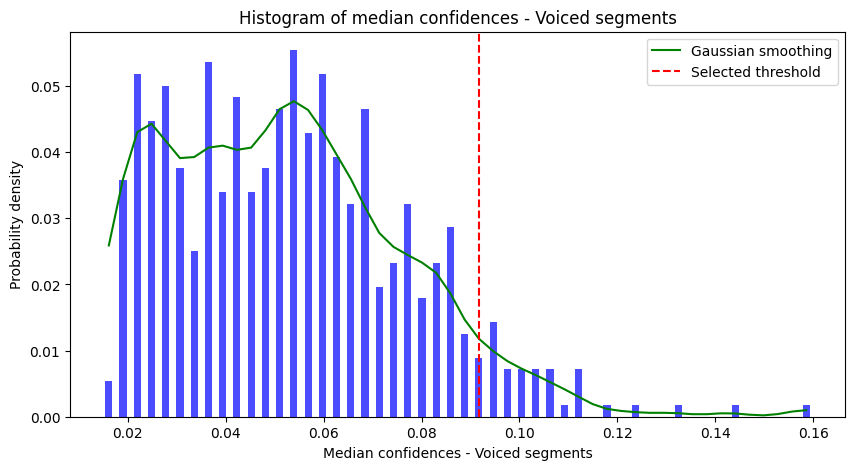

In [32]:
# Removing segments with low confidence estimation
median_conf = u.median_confidences(conf, voiced_segments)
plt.figure(figsize=(10, 5))
hist, bin_edges = np.histogram(median_conf, bins = 50, density = True)
hist = hist/np.sum(hist)
peaks = u.find_minimas(hist, height = 0.01)
gaussian_fit = u.gaussian_filter(hist, 10, sigma = 1.5)
print("Selected threshold:", bin_edges[peaks[0]])
plt.bar(bin_edges[:-1], hist, width = 0.5*(bin_edges[1] - bin_edges[0]), color = 'b', alpha = 0.7)
plt.plot(bin_edges[:-1], gaussian_fit, color = 'g', label = "Gaussian smoothing")
plt.axvline(x = bin_edges[peaks[0]], color = 'r', linestyle = '--', label = "Selected threshold")
plt.xlabel("Median confidences - Voiced segments")
plt.ylabel("Probability density")
plt.title("Histogram of median confidences - Voiced segments")
plt.legend()
plt.show()

In [33]:
# Keeping and discarding segments based on threshold
f0_filt = f0.copy()
f0_disc = f0.copy()
# threshold = bin_edges[peaks[0]]
# Manual threshold
threshold = 0.02
for i in range(len(voiced_segments)):
    if median_conf[i] < threshold:
        start = voiced_segments[i][0]
        end = voiced_segments[i][1] + 1
        f0_filt[start:end] = 0
    if median_conf[i] > threshold:
        start = voiced_segments[i][0]
        end = voiced_segments[i][1] + 1
        f0_disc[start:end] = 0

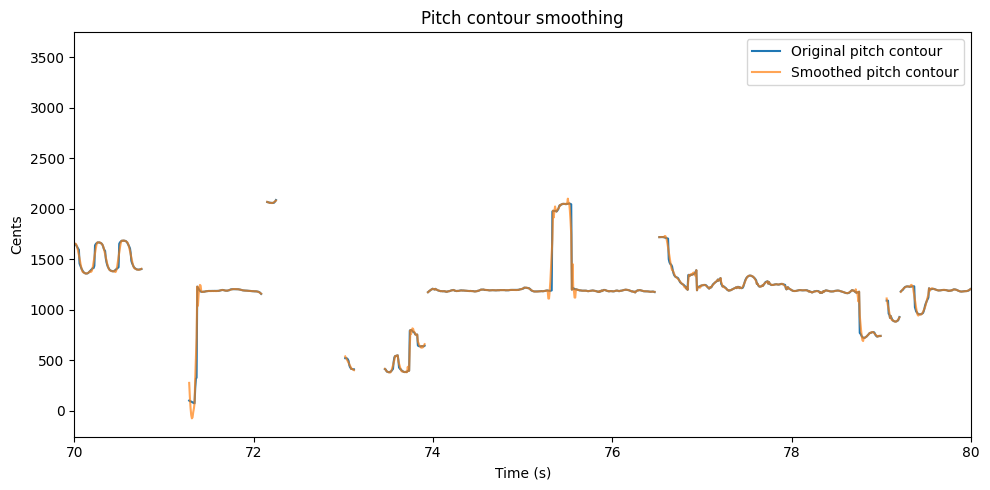

In [34]:
# Pitch contour smoothing and interpolation
window_ms = 100
window_samples = u.ms_to_samples(window_ms, 133)
f0_smoothed = u.savitsky_golay_filter(f0_filt, window_samples, 2, peak = True)

plt.figure(figsize=(10, 5))
plt.plot(times, u.hz_to_cents(f0_filt, tonic_violin), label = "Original pitch contour")
plt.plot(times, u.hz_to_cents(f0_smoothed, tonic_violin), label = "Smoothed pitch contour", alpha = 0.7)
plt.xlabel("Time (s)")
plt.ylabel("Cents")
plt.xlim(70,80)
# plt.yticks(list(notes_dict.values()), list(notes_dict.keys()))
plt.title("Pitch contour smoothing")
plt.legend()
plt.tight_layout()
plt.show()

#### Vocal and violin contours (only for alaapana)

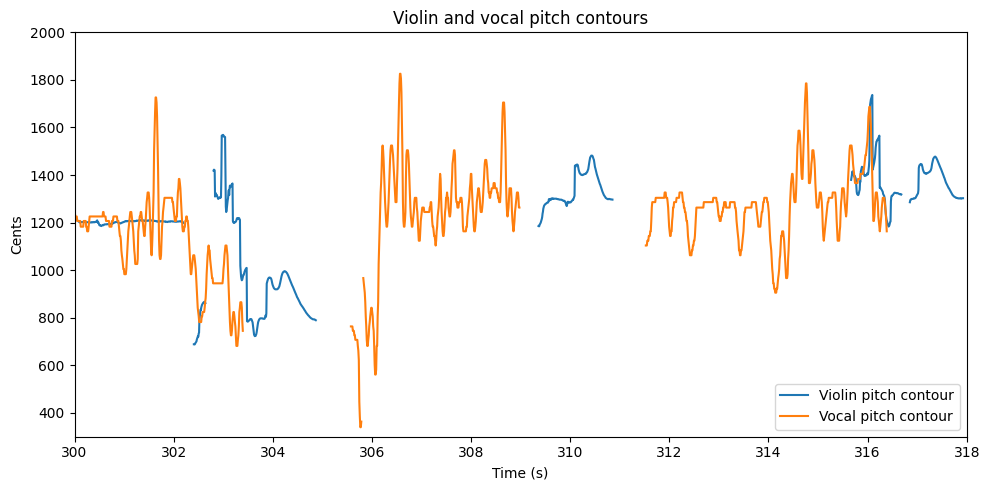

In [114]:
# Plot vocal and violin pitch contours
plt.figure(figsize=(10, 5))
plt.plot(times, u.hz_to_cents(f0_filt, tonic), label = "Violin pitch contour")
plt.plot(times_vocal, u.hz_to_cents(f0_vocal, tonic_vocal), label = "Vocal pitch contour")
plt.xlabel("Time (s)")
plt.ylabel("Cents")
plt.title("Violin and vocal pitch contours")
plt.xlim(300, 318)
plt.ylim(300, 2000)
plt.legend(loc = "lower right")  
plt.tight_layout()
plt.show()


In [36]:
# Save processed pitch contour
processedfile = pitchfile.replace(".pitch", "-processed.pitch")
np.savetxt(processedfile, np.array([times, f0_smoothed]).T)